# Project Tasks

In the first two assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should try both combining the profiles with activities and using each data type independently.
* Implement different models of your choice for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier to predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session.

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially at the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Mutational catalogs and activities - WGS data

In [4]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [5]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [7]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [9]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [12]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
def process_profile_data(mut_dfs):
    """
    1. Transposes mutation catalogs so samples are rows.
    2. Normalizes counts to sum to 1 (Frequency).
    3. Extracts Cancer Type labels.
    """
    # Concatenate all mutation dataframes horizontally (aligning on Mutation type/Trinucleotide)
    # We assume all dfs have the same 96 rows sorted identically.
    # First, let's create a combined dataframe by dropping the info columns on subsequent dfs
    
    base_df = mut_dfs[0].copy()
    
    # Create the 96-channel index (e.g., C>A_ACA)
    channel_index = base_df['Mutation type'] + "_" + base_df['Trinucleotide']
    
    combined_df = pd.DataFrame(index=channel_index)
    
    for df in mut_dfs:
        # Drop metadata columns to get just sample counts
        temp = df.drop(['Mutation type', 'Trinucleotide'], axis=1)
        # Set index for alignment
        temp.index = channel_index
        combined_df = pd.concat([combined_df, temp], axis=1)
        
    # Transpose: Rows = Samples, Columns = 96 Mutation Channels
    X = combined_df.T
    
    # Extract Labels (Cancer Type) from the index (Sample Name: "CancerType::SampleID")
    # We split by "::" and take the first part
    y = X.index.map(lambda x: x.split("::")[0])
    
    # NORMALIZE: Sum of row = 1 (to handle WGS vs WES scale differences)
    X_norm = X.div(X.sum(axis=1), axis=0)
    
    return X_norm, y

def process_activity_data(act_dfs):
    """
    1. Standardizes index to match Profile data (CancerType::SampleID).
    2. Concatenates all activity dataframes.
    """
    combined_act = pd.DataFrame()
    
    for df in act_dfs:
        temp = df.copy()
        # Create Index matching the Profile format: "CancerType::SampleName"
        # Note: Adjust column names if they differ slightly across files
        temp['index_id'] = temp['Cancer Types'] + "::" + temp['Sample Names']
        temp = temp.set_index('index_id')
        
        # Drop metadata
        cols_to_drop = ['Cancer Types', 'Sample Names', 'Accuracy']
        temp = temp.drop([c for c in cols_to_drop if c in temp.columns], axis=1)
        
        combined_act = pd.concat([combined_act, temp], axis=0)
    
    # Fill NaNs with 0 (in case some files have different sets of signatures)
    combined_act = combined_act.fillna(0)
    
    # Normalize activities to sum to 1 (Optional but good for comparison)
    combined_act = combined_act.div(combined_act.sum(axis=1), axis=0)
    
    return combined_act

# --- Execution ---

# 1. Prepare Lists of Dataframes (Assuming these are already loaded in your notebook)
#list_muts = [PCAWG_wgs_mut, nonPCAWG_wgs_mut]
#list_acts = [PCAWG_wgs_act, nonPCAWG_wgs_act]
list_muts = [PCAWG_wgs_mut]
list_acts = [PCAWG_wgs_act]

'''
During our data exploration, we observed that combining PCAWG WGS data with Other WGS data reduced overall model accuracy by ~10%. 
We hypothesize that this drop is due to batch effects—PCAWG data is uniformly harmonized through a single pipeline, 
whereas external datasets introduce technical noise and variance in mutation calling. 
To ensure our models learn true biological etiology rather than laboratory batch effects, we restricted our final training to the PCAWG cohort.
'''

# 2. Process Data
print("Processing Profiles...")
X_profiles, y_labels = process_profile_data(list_muts)

print("Processing Activities...")
X_activities = process_activity_data(list_acts)

# 3. Create Combined Dataset
# Use intersection of indices to ensure we only keep samples present in both
common_indices = X_profiles.index.intersection(X_activities.index)

X_prof_common = X_profiles.loc[common_indices]
X_act_common = X_activities.loc[common_indices]
y_common = y_labels[X_profiles.index.isin(common_indices)]

# Concatenate for the "Combined" feature set
X_combined = pd.concat([X_prof_common, X_act_common], axis=1)

print(f"Total Samples Processed: {len(y_common)}")
print(f"Profile Features: {X_prof_common.shape[1]}")
print(f"Activity Features: {X_act_common.shape[1]}")

Processing Profiles...
Processing Activities...
Total Samples Processed: 2780
Profile Features: 96
Activity Features: 65


================ Evaluating Expanded Models ================

Training Logistic Regression...
--> Logistic Regression Test Accuracy: 0.4478

Training Random Forest...
--> Random Forest Test Accuracy: 0.7446

Training Support Vector Machine...
--> Support Vector Machine Test Accuracy: 0.5378

Training MLP...


d:\Conda\envs\MLbio\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


--> MLP Test Accuracy: 0.7806

Best Model: MLP with 0.7806 Accuracy 



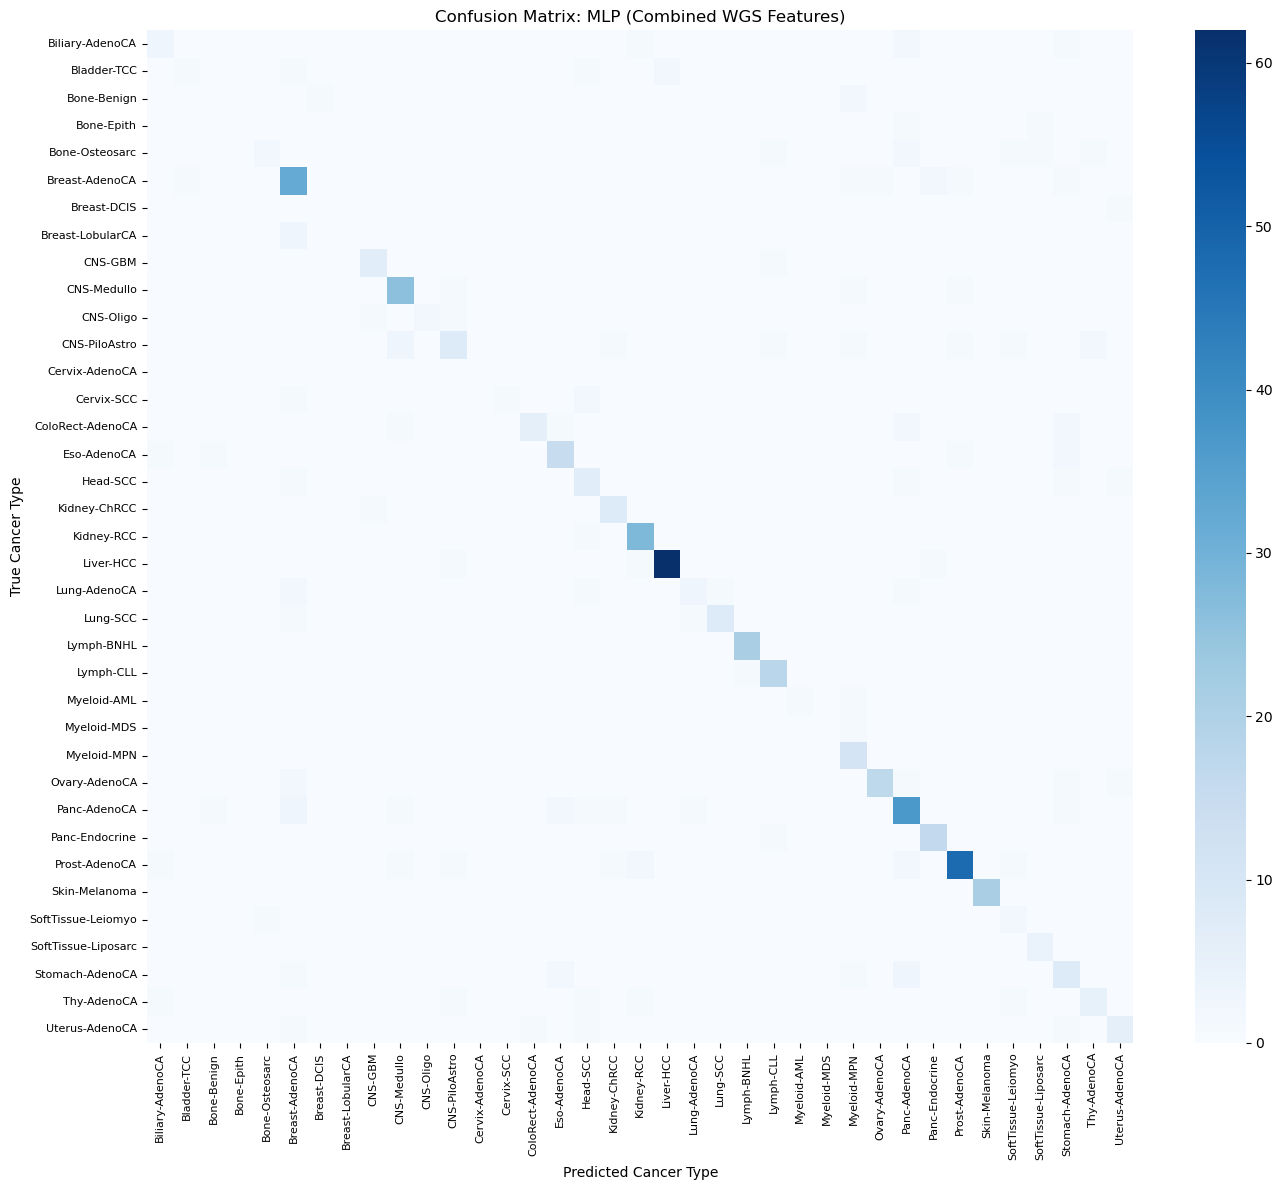


        Model Performance Summary        
                 Model  Test Accuracy
                   MLP       0.780576
         Random Forest       0.744604
Support Vector Machine       0.537770
   Logistic Regression       0.447842


In [23]:
# 1. Split the Combined WGS data
# (Assuming X_combined and y_common are already defined from the previous steps)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_common, test_size=0.2, random_state=42, stratify=y_common
)

# 2. Define an expanded dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    # Note: Gradient Boosting can be slow. If it takes too long, you can comment it out.
    #"Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

# 3. Train and evaluate models
print("================ Evaluating Expanded Models ================\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"accuracy": acc, "y_pred": y_pred, "model": model}
    print(f"--> {name} Test Accuracy: {acc:.4f}\n")

# 4. Find the best model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
print(f"Best Model: {best_model_name} with {results[best_model_name]['accuracy']:.4f} Accuracy \n")

# 5. Plot Confusion Matrix for the BEST performing model
y_pred_best = results[best_model_name]['y_pred']
unique_labels = sorted(np.unique(y_common))

cm = confusion_matrix(y_test, y_pred_best, labels=unique_labels)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f"Confusion Matrix: {best_model_name} (Combined WGS Features)")
plt.ylabel('True Cancer Type')
plt.xlabel('Predicted Cancer Type')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 6. Performance Summary Table
summary_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Accuracy": [results[m]["accuracy"] for m in results]
}).sort_values(by="Test Accuracy", ascending=False)

print("\n=========================================")
print("        Model Performance Summary        ")
print("=========================================")
print(summary_df.to_string(index=False))

Data Split -> Train: 1945 | Validation: 418 | Test: 417

Starting PyTorch Training for 300 Epochs...
Epoch [25/300] | Train Loss: 0.7601, Train Acc: 0.7661 | Val Loss: 0.8040, Val Acc: 0.7871
Epoch [50/300] | Train Loss: 0.5929, Train Acc: 0.8026 | Val Loss: 0.7829, Val Acc: 0.8110
Epoch [75/300] | Train Loss: 0.5161, Train Acc: 0.8303 | Val Loss: 0.7364, Val Acc: 0.8182
Epoch [100/300] | Train Loss: 0.4899, Train Acc: 0.8509 | Val Loss: 0.7494, Val Acc: 0.8230
Epoch [125/300] | Train Loss: 0.4074, Train Acc: 0.8694 | Val Loss: 0.7453, Val Acc: 0.8397
Epoch [150/300] | Train Loss: 0.4717, Train Acc: 0.8468 | Val Loss: 0.7016, Val Acc: 0.8254
Epoch [175/300] | Train Loss: 0.4228, Train Acc: 0.8576 | Val Loss: 0.7484, Val Acc: 0.8230
Epoch [200/300] | Train Loss: 0.4299, Train Acc: 0.8643 | Val Loss: 0.7994, Val Acc: 0.8158
Epoch [225/300] | Train Loss: 0.4040, Train Acc: 0.8766 | Val Loss: 0.7734, Val Acc: 0.8206
Epoch [250/300] | Train Loss: 0.4107, Train Acc: 0.8725 | Val Loss: 0.7818

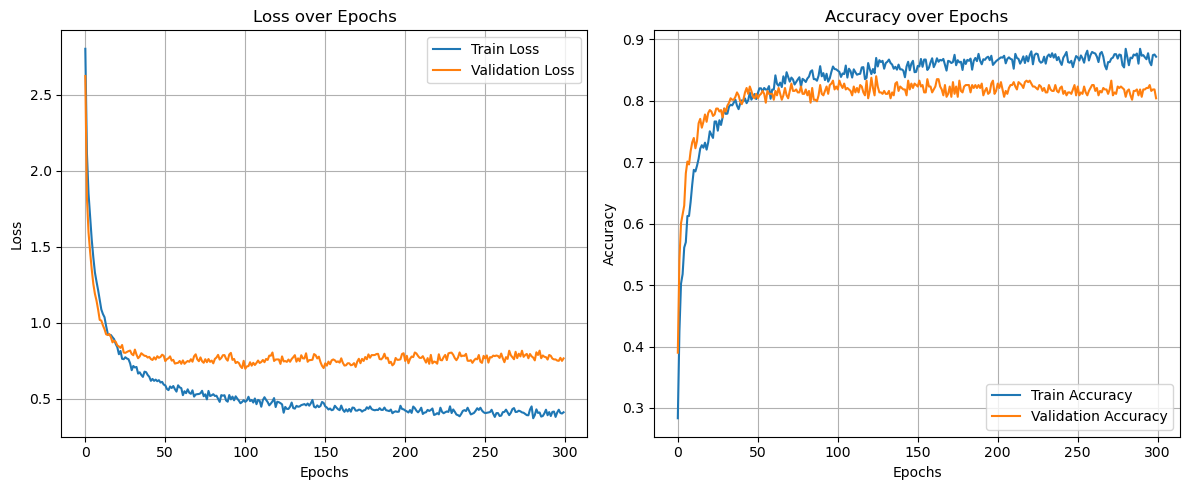

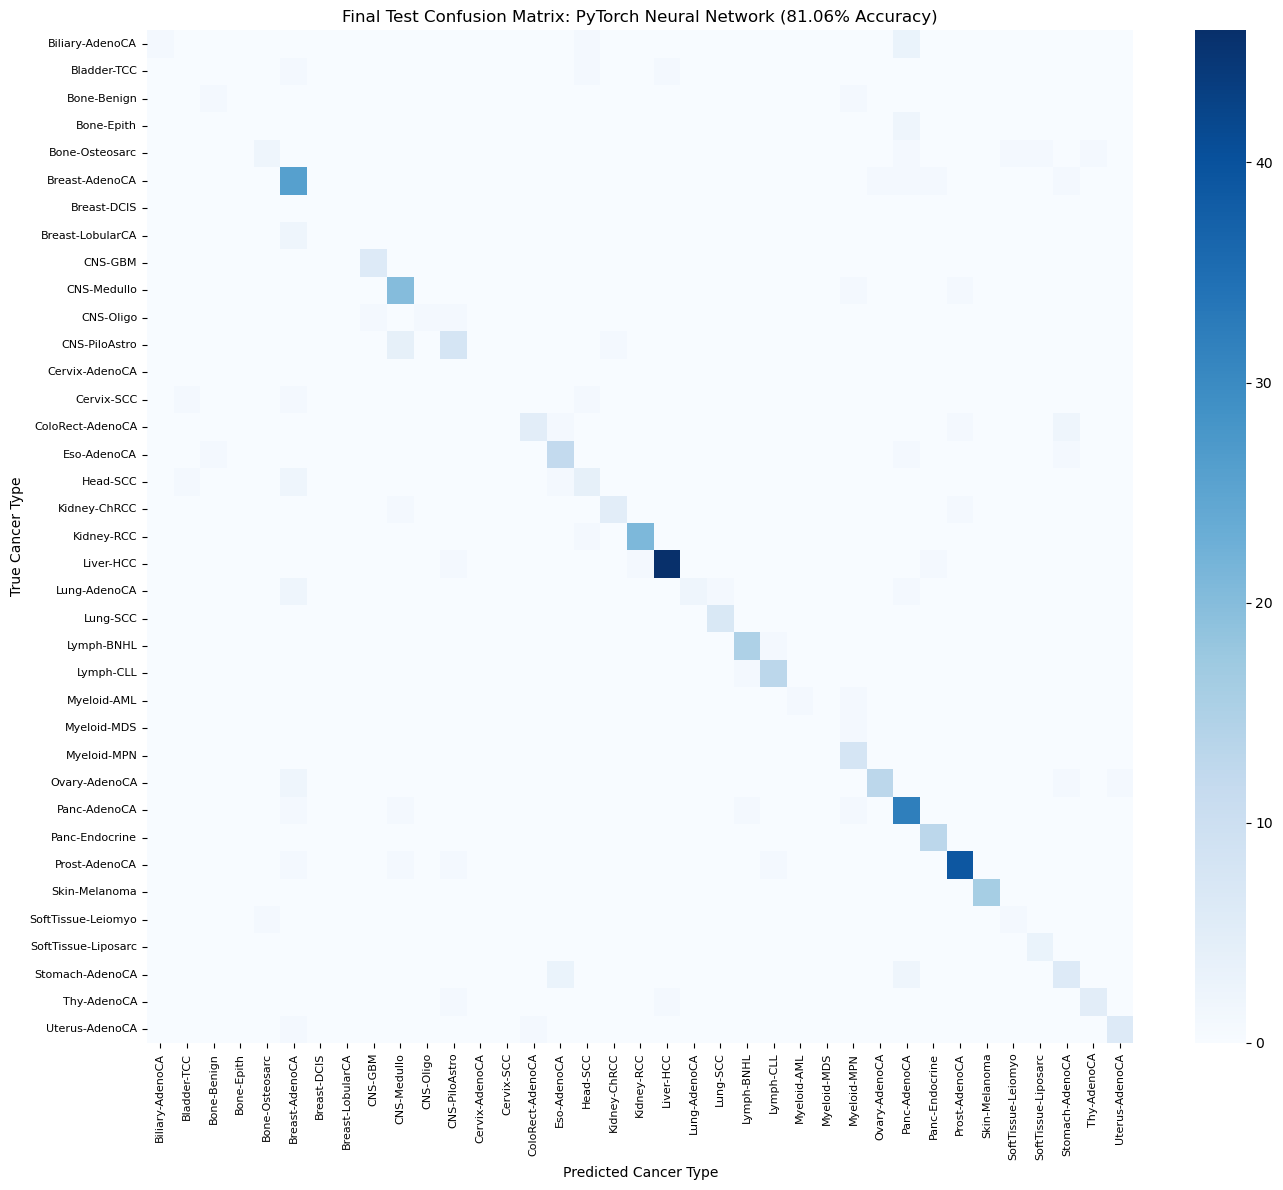

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

# ==========================================
# 1. Train / Validation / Test Split
# ==========================================
# Assuming X_combined and y_common are available from earlier cells

# First split: Extract 15% for the FINAL TEST set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y_common, test_size=0.15, random_state=42, stratify=y_common
)

# Second split: Split the remaining 85% into Train (70%) and Validation (15%)
# 0.15 / 0.85 ≈ 0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Data Split -> Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
input_dim = X_train.shape[1]

# Convert pandas/numpy arrays to PyTorch Tensors
def create_tensor_dataset(X, y):
    X_tensor = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
    y_tensor = torch.LongTensor(y)
    return TensorDataset(X_tensor, y_tensor)

train_loader = DataLoader(create_tensor_dataset(X_train, y_train_encoded), batch_size=32, shuffle=True)
val_loader = DataLoader(create_tensor_dataset(X_val, y_val_encoded), batch_size=32, shuffle=False)
test_loader = DataLoader(create_tensor_dataset(X_test, y_test_encoded), batch_size=32, shuffle=False)

# ==========================================
# 2. Define the PyTorch Neural Network
# ==========================================
class CancerClassifierNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CancerClassifierNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = CancerClassifierNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# ==========================================
# 3. Train the Model with Validation
# ==========================================
epochs = 300
best_val_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\nStarting PyTorch Training for {epochs} Epochs...")

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_train_loss, train_correct, train_total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()
        train_total += labels.size(0)
        
    epoch_train_loss = running_train_loss / train_total
    epoch_train_acc = train_correct / train_total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            val_total += labels.size(0)
            
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    # Save best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
    
    # Print progress every 25 epochs
    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Restore the model to the best weights found during training
model.load_state_dict(best_model_weights)
print(f"\nTraining complete. Loaded best model weights (Val Loss: {best_val_loss:.4f})")

# ==========================================
# 4. Final Evaluation on UNSEEN TEST DATA
# ==========================================
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_targets.extend(labels.numpy())

# Calculate Final Test Accuracy
final_test_accuracy = accuracy_score(test_targets, test_preds)
print(f"\n=========================================")
print(f" Final PyTorch Test Accuracy: {final_test_accuracy:.4f} ")
print(f"=========================================\n")

# ==========================================
# 5. Visualizations
# ==========================================
# 5A. Plot Training and Validation Curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5B. Plot Final Test Confusion Matrix
decoded_preds = label_encoder.inverse_transform(test_preds)
decoded_targets = label_encoder.inverse_transform(test_targets)
unique_labels = label_encoder.classes_

cm = confusion_matrix(decoded_targets, decoded_preds, labels=unique_labels)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f"Final Test Confusion Matrix: PyTorch Neural Network ({final_test_accuracy:.2%} Accuracy)")
plt.ylabel('True Cancer Type')
plt.xlabel('Predicted Cancer Type')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()